<a href="https://colab.research.google.com/github/levynlee/ESAA/blob/main/0909_%ED%95%84%EC%82%AC%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER07. 앙상블 학습과 랜덤 포레스트**

- 무작위로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모은다면, 이렇게 모든 답이 전문가의 답보다 나음 (wisdom of crowd)
- 비슷하게 일련의 예측기(분류기나 회귀 모델)로부터 예측을 수집(**앙상블 학습**)하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음
- 일련의 예측기 = **양상블**
- 앙상블 학습 알고리즘 = **앙상블 방법**

- 앙상블 방법의 예: 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있음
- 예측하려면: 모든 개별 트리의 예측 구하기 -> 가장 많은 선택을 받은 클래스를 예측으로 삼기
- 결정 트리의 앙상블 = **랜덤 포레스트**: 간단한 방법이지만 가장 강력한 머신러닝 알고리즘 중 하나

- 프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 이미 만든 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만듦
- 머신러닝 경연 대회에서 우승하는 솔루션은 여러 가지 앙상블 방법을 사용한 경우가 많음

- 가장 인기 있는 앙상블 방법: 배깅, 부스팅, 스태깅, ...

## **7.1 투표 기반 분류기**

- 정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정
- 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있을 것
![image.png](attachment:6d2aebd2-78b8-4c6d-895e-6cc9fdf84197.png)
- 더 좋은 분류기를 만드는 간단한 방법: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측  
  => 이렇게 다수결 투표로 정해지는 분류기: **직접 투표 hard voting** 분류기
![image.png](attachment:26d1ad6e-7914-4b36-a8a9-478818ffdd0f.png)
- 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음
- 각 분류기가 **약한 학습기 weak learner** (랜덤 추측보다 조금 더 높은 성능을 나타내는 분류기)일지라도 충분하게 다양하고 많다면 앙상블은 (높은 정확도를 내는) **강한 학습기 strong learner**가 될 수 있음  
  => 어떻게?
- 동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 동전 가정
  - 이 동전을 1000번 던진다면 대략 510번은 앞면, 490번은 뒷면이 나올 것
  - 수학적으로 계산해보면 1000번을 던진 후 앞면이 다수가 될 확률은 75%에 가까움
  - 더 많이 던질수록 확률은 증가 (10000번 던지면 확률이 97% 이상으로 올라감): 큰 수의 법칙
  - 동전을 자꾸 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워짐
![image.png](attachment:e2cc2b30-581b-426c-a943-33fa6d7ac441.png)
- 균형이 틀어진 동전을 10번 실험한 그래프
  - 던진 횟수가 증가할수록 앞면이 나올 확률 51%에 가까워짐
- 이와 비슷하게 (무작위 추출보다 조금 더 나은) 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축한다고 가정
  - 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음
  - BUT 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능
  - BUT 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음
  - 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐

- 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기 (VotingClassifier)를 만들고 훈련시키는 코드

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

- 각 분류기의 테스트셋 정확도 확인

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.85
SVC 0.85
VotingClassifier 0.85


- 모든 분류기가 클래스의 확률 예측 가능
- 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스 예측 => "간접 투표 soft voting": 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음

## **7.2 배깅과 페이스팅**

- 다양한 분류기를 만드는 또 다른 방법: 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것
- **배깅 bagging**: 훈련 세트에서 중복을 허용하여 샘플링하는 방식. bootstrap aggregating의 줄임말.
- **페이스팅 pasting**: 중복을 허용하지 않고 샘플링하는 방식
- 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능
- BUT 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능
![image.png](attachment:400993b2-6743-47fa-a617-e8774657679f.png)
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
  - 수집함수는 전형적으로 **분류**일 때는 **통계적 최빈값**이고 **회귀**에 대해서는 **평균**을 계산
  - 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소
  - 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

### **7.2.1 사이킷런의 배깅과 페이스팅**

- 사이킷런은 배깅과 페이스팅을 위해 BaangClassifier (회귀의 경우 BaggingRegressor) 제공
- n_estimators: 결정 트리 분류기 500개의 앙상블 훈련
- max_samples: 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 50개의 샘플로 훈련됨
- n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 (-1로 지정 시 가용한 모든 코어 사용)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)   #배깅 : bootstrap = True / 페이스팅 : False
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

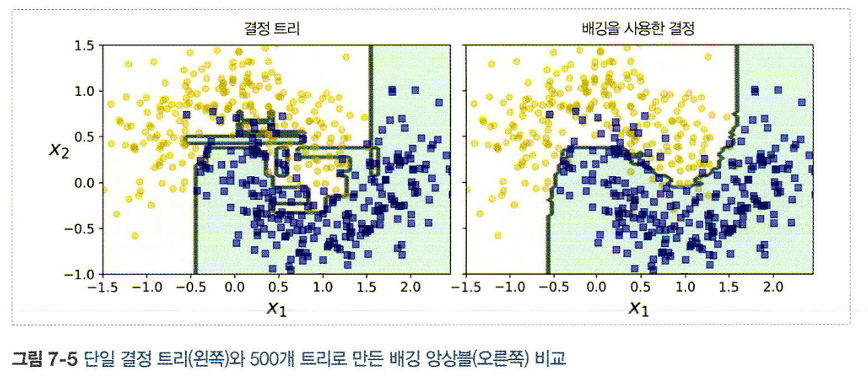

- 앙상블이 비슷한 편향에서 더 작은 분산을 만듦 (훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙)
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
- BUT 다양성을 추가 --> 예측기들의 상관관계를 줄임 --> 앙상블의 분산 감소
- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호
- 시간과 CPU 파워에 여유가 있다면 교차 검즈응로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽 선택

### **7.2.2 oob 평가**

- 배깅 사용시: 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
- BaggingClassifier: 중복 허용(bootstrap=True), 훈련 세트의 크기만큼인 m개의 샘플 선택 --> 각 예측기에 훈련 샘플의 약 63% 정도만 샘플링됨 --> 선택되지 않은 훈련 샘플의 나머지 37%가 **oob (out-of-bag)** 샘플
- 예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가 가능
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음
- oob_score=True 지정 시 훈련이 끝난 후 자동으로 oob 평가 수행

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.75

- oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인
- 아래 예시: oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 68.25%로, 음성 클래스에 속할 확률을 31.75%로 추정


In [8]:
bag_clf.oob_decision_function_

array([[0.01941748, 0.98058252],
       [1.        , 0.        ],
       [0.43406593, 0.56593407],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.06976744, 0.93023256],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.56886228, 0.43113772],
       [0.03783784, 0.96216216],
       [0.98029557, 0.01970443],
       [0.21808511, 0.78191489],
       [0.96984925, 0.03015075],
       [0.11398964, 0.88601036],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.02525253, 0.97474747],
       [0.        , 1.        ],
       [0.02840909, 0.97159091],
       [1.        , 0.        ],
       [0.96858639, 0.03141361],
       [0.03664921, 0.96335079],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.42857143, 0.57142857],
       [0.        , 1.        ],
       [0.01069519, 0.98930481],
       [0.

## **7.3 랜덤 패치와 랜덤 서브스페이스**

- BaggingClassifier는 특성 샘플링을 지원
- 샘플링은 max_features, bootstrap_features 두 매개변수로 조절됨
- 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링
- 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
- 이미와 같은 매우 고차원의 데이터셋을 다룰 때 유용
- 훈련 특성과 샘플을 모두 샘플링하는 것: **랜덤 패치 방식 random patches method**
- 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0) 특성은 샘플링하는 것(bootstrap_features=True, max_features는 1.0보다 작게 설정): **랜덤 서브스페이스 방식 random subspaces method**
- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

## **7.4 랜덤 포레스트**

- 랜덤 포레스트: 배깅 또는 페이스팅을 적용한 결정 트리의 앙상블
- 전형적으로 max_samples를 훈련 세트의 크기로 지정

In [21]:
# 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes=16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 **무작위성**을 더 주입  
  => 트리를 더욱 다양하게 만들고, 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델 만듦

In [22]:
# BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

### **7.4.1 엑스트라 트리**

- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
- 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할 선택  
- 이처럼 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 extremely randomized trees 앙상블** 또는 **엑스트라 트리**라고 함
- 여기서도 편향이 늘어나지만 대신 분산을 낮춤
- 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름
- 엑스트라 트리를 만들기 위해 사이킷런의 ExtraTreesClassifier 사용

### **7.4.2 특성 중요도**

- 랜덤 포레스트의 또 다른 장점: 특성의 상대적 중요도를 측정하기 쉬움
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도 전체 합이 1이 되도록 결괏값을 정규화

In [23]:
# iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.08481790393193653
sepal width (cm) 0.02175633288973496
petal length (cm) 0.45163250529352494
petal width (cm) 0.44179325788480367


- 가장 중요한 특성: 꽃잎의 길이(45%), 너비(44%)
- 꽃받침의 길이와 너비는 비교적 덜 중요해보임

- 랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리

## **7.5 부스팅**

- 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
- 가장 인기 있는 부스팅 방법: **에이다부스트 AdaBoost(adaptive boosting)**와 **그레이디언트 부스팅**

### **7.5.1 에이다부스트**

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이기 --> 새로운 예측기가 학습하기 어려운 샘플에 점점 더 맞춰지게 됨
- 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음
  - 경사 하강법은 비용함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정
  - 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가
- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦
- BUT 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### **7.5.2 그레디언트 부스팅**

- 에이다부스트와 같이 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- BUT 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신, 이전 예측기가 만든 **잔여 오차 residual error**에 새로운 예측기를 학습시킴

In [27]:
# 결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제
# 1. DecisionTreeRegressor를 훈련 세트(잡음이 섞인 2차 곡선 형태의 훈련 세트)에 학습시키기
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [28]:
# 2. 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시키기
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [29]:
# 3. 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시키기
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
# 이제 세 개의 트리를 포함하는 앙상블 모델이 생김
# 4. 새로운 샘플에 대한 예측을 만들기 위해 모든 트리의 예측을 더하기
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [32]:
# 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시키기
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=2, learning_rate = 1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

- learning_rate 매개변수: 각 트리의 기여 정도 조절
  - 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요 BUT 일반적으로 예측의 성능은 좋아짐 => **축소 shrinkage**
- **최적의 트리 수**를 찾기 위해 **조기 종료 기법** 사용
  - 간단하게 구현하려면 stagged_predict() 메서드 사용: 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자 iterator 반환

In [33]:
# 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차 측정 + 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블 훈련
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=116)

- 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 대신
- 실제로 훈련을 중지하는 방법으로도 조기 종료 구현 가능
- warm_start=True: 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 함

In [34]:
# 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추는 코드
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up +=1
    if error_going_up == 5:
      break # 조기 종료

- GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수 지원
  - eg) subsample=0.25: 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨
- 편향이 높아지는 대신 분산이 낮아짐
- 훈련 속도가 높아짐  

=> **확률적 그레이디언트 부스팅 stochastic gradient boosting**

- 최적화된 그레이디언트 부스팅 구현으로 XGBoost 파이썬 라이브러리가 유명
- XGBoost = 익스트림 그레이디언트 부스팅의 약자
- 이 패키지의 목표: 매우 빠른 속도, 확장성, 이식성

In [18]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

In [35]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

## **7.6 스태킹**

- '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?'
- 마지막 예측기 = **블렌더 blender** or **메타 학습기 meta learner**
- 블렌더를 학습시키는 일반적인 방법: **홀드 아웃 hold-out** 세트 사용